### Imports

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
import torchvision
import torchvision.transforms as transforms

In [7]:
from torchvision.transforms import InterpolationMode

In [8]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import BoundedParameter

In [9]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [10]:
# datasets of wavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [11]:
from tqdm import tqdm

In [12]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Optical Neural Network

In that example notebook we will try to realize a simple architecture of an optical neural network from [an article](https://www.science.org/doi/10.1126/science.aat8084).

> In general, the phase and amplitude of eachneuron can be learnable parameters, providinga complex-valued modulation at each layer, which improves the inference performance of the diffractive network.

> ... we first trained it as a digit classifierto perform automated classification of hand-written digits, from $0$ to $9$. Forthis task, phase-only transmission masks weredesigned by training **a five-layer** $D^2 NN$ with $55,000$ images ($5000$ validation images) from the MNIST handwritten digit data-base.

>  We then used continuous-wave illumination at $0.4$ $THz$...

Some info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) (information about MNIST classification):

> Because we consider coherent illumination, the input information can be encoded in the amplitude and/or phase channels of the input plane.

> For each layer of the $D^2NN$, we set we set the neuron size to be $400$ $\mu m$...

> At the detector/output plane, we measured the intensity of the network output...

# 1. Simulation parameters

In [13]:
working_frequency = 0.4 * 1e12 # [Hz]
c_const = 299_792_458  # [m / s]

In [14]:
working_wavelength = c_const / working_frequency  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 749.481 um


In [15]:
# physical size of each layer (from the article) - (8 x 8) [cm]
x_layer_size = 8 * 1e-2  # [m]
y_layer_size = x_layer_size

In [16]:
# number of neurons in simulation
neuron_size = 400 * 1e-6  # [m]

x_layer_nodes = int(x_layer_size / neuron_size)
y_layer_nodes = int(y_layer_size / neuron_size)

In [17]:
y_layer_nodes

200

In [18]:
# simulation parameters for the rest of the notebook

sim_params = SimulationParameters(
    x_size=x_layer_size,  # [m]
    y_size=y_layer_size,  # [m]
    x_nodes=x_layer_nodes,
    y_nodes=y_layer_nodes,
    wavelength=working_wavelength,  # [m]
)

# 2. Dataset preparation

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [19]:
# initialize a directory for a dataset
data_filepath = './data'  # folder to store data

### 2.1.1. Train/Test datasets of images

In [20]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=True,  # for train dataset
    download=False,
)

In [21]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=False,  # for test dataset
    download=False,
)

In [22]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Train/Test datasets of wavefronts

In [23]:
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(int(y_layer_nodes / 2), int(x_layer_nodes / 2)),
          interpolation=InterpolationMode.NEAREST,
      ),
  ]  
)

In [25]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = WavefrontsDatasetSimple(
    images_ds=mnist_train_ds,  # dataset of images
    image_transforms_comp=image_transform_for_ds,  # image transformation
    sim_params=sim_params,  # simulation parameters
)

In [26]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = WavefrontsDatasetSimple(
    images_ds=mnist_test_ds,  # dataset of images
    image_transforms_comp=image_transform_for_ds,  # image transformation
    sim_params=sim_params,  # simulation parameters
)

In [27]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


# 3. Optical network

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> Following the corresponding $D^2NN$ design, the axial distance between two successive 3D-printed layers was set to be $3.0$ $cm$...

> The distance between detector/output plane and the last layer of the optical neural network was adjusted as $3$ $cm$...

In [29]:
number_of_diffractive_layers = 5  # number of diffractive layers
distance_between_difractive_layers = 3 * 1e-2  # [m]

## 3.1. Architecture


### 3.1.1. List of Elements

> To help with the 3D-printing and fabrication of the $D^2NN$ design, a sigmoid function was used to limit the phase value of each neuron to $0-2π$ and $0-π$, for imaging and classifier networks, respectively.

In [30]:
MAX_PHASE = np.pi

In [31]:
def get_const_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_diffractive_layer(
    difflayer_sim_params,
    mask_seed  # for reproducability
):
    """
    Returns DiffractiveLayer with a random mask.
    """
    random_mask = torch.rand(
        size=(difflayer_sim_params.y_nodes, difflayer_sim_params.x_nodes),
        generator=torch.Generator().manual_seed(mask_seed)
    ) * (MAX_PHASE)
    return elements.DiffractiveLayer(
        simulation_parameters=difflayer_sim_params,
        mask=BoundedParameter(
            random_mask,
            min_value=0,
            max_value=MAX_PHASE
        ),  # HERE WE ARE USING BOUNDED PARAMETER!
        mask_norm=1
    )

In [32]:
lin_architecture_elements_list = []  # list of elements
# Comment: Lin - a surname of the first author of the article
freespace_method_selected = 'fresnel'  # 'AS' returns nan's

diffractive_layers_seeds = torch.randint(
    low=0, high=100,
    size=(number_of_diffractive_layers,),
    generator=torch.Generator().manual_seed(123)  # to generate the same set of initial masks
)

# compose architecture
for ind_layer in range(number_of_diffractive_layers):
    if ind_layer == 0:
        # first FreeSpace layer before first DiffractiveLayer
        lin_architecture_elements_list.append(
            get_const_free_space(
                sim_params,  # simulation parameters for the notebook
                distance_between_difractive_layers,  # in [m]
                freespace_method=freespace_method_selected,
            )
        )
    # add DiffractiveLayer
    lin_architecture_elements_list.append(
        get_diffractive_layer(
            sim_params,  # simulation parameters for the notebook
            mask_seed=diffractive_layers_seeds[ind_layer].item()
        )
    )
    # add FreeSpace
    lin_architecture_elements_list.append(
        get_const_free_space(
            sim_params,  # simulation parameters for the notebook
            distance_between_difractive_layers,  # in [m]
            freespace_method=freespace_method_selected,
        )
    )


# add Detector in the end of the system
lin_architecture_elements_list.append(
    Detector(
        simulation_parameters=sim_params,
        func='intensity'  # detector that returns intensity
    )
)

print(f'Number of elements in the system (including Detector): {len(lin_architecture_elements_list)}')

Number of elements in the system (including Detector): 12


### 3.1.2. Compose `LinearOpticalSetup`

In [33]:
lin_optical_setup = LinearOpticalSetup(
    elements=lin_architecture_elements_list
)
# Comment: Lin - a surname of the first author of the article

In [34]:
lin_optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): DiffractiveLayer()
  (2): FreeSpace()
  (3): DiffractiveLayer()
  (4): FreeSpace()
  (5): DiffractiveLayer()
  (6): FreeSpace()
  (7): DiffractiveLayer()
  (8): FreeSpace()
  (9): DiffractiveLayer()
  (10): FreeSpace()
  (11): Detector()
)

### 3.1.3 Detector processor

In [35]:
number_of_classes = 10

#### Detector mask

In [36]:
# size of each segment
x_segment_nodes = int(x_layer_nodes / 9)
y_segment_nodes = int(y_layer_nodes / 9)  # each segment of size = (y_segment_nodes, x_segment_nodes)

In [37]:
# coordinates of segments left upper corners (in nodes)
segments_corners = {}

for ind, label in enumerate(range(3)):
    segments_corners[label] = (
        y_layer_nodes // 4 - y_segment_nodes // 2,
        2 * x_segment_nodes + ind * (2 * x_segment_nodes)
    )

for ind, label in enumerate(range(3, 7)):
    segments_corners[label] = (
        y_layer_nodes // 2 - y_segment_nodes // 2,
        x_segment_nodes + ind * (2 * x_segment_nodes)
    )

for ind, label in enumerate(range(7, 10)):
    segments_corners[label] = (
        3 * y_layer_nodes // 4 - y_segment_nodes // 2,
        2 * x_segment_nodes + ind * (2 * x_segment_nodes)
    )

In [38]:
# create a mask for detector
detector_mask = torch.ones(
    size=(y_layer_nodes, x_layer_nodes),
) * (-1)

for label in segments_corners.keys():
    y_node, x_node = segments_corners[label]
    detector_mask[y_node:y_node + y_segment_nodes, x_node:x_node + x_segment_nodes] = label

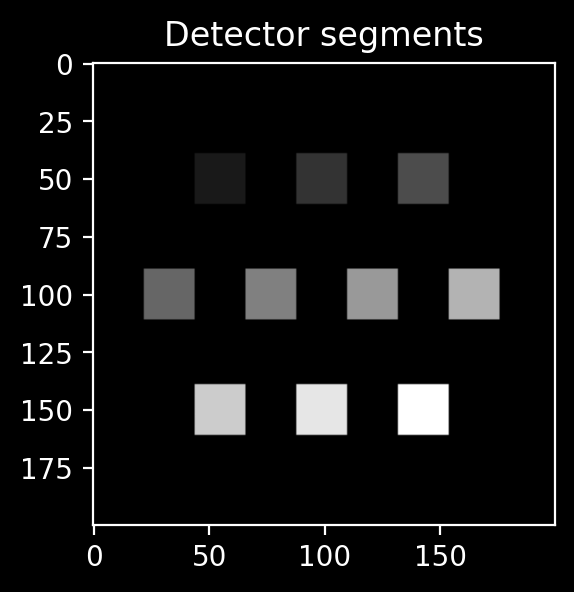

In [39]:
# let's take a look at a beam intensity distribution
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(detector_mask, cmap='grey')

plt.show()

#### Detector processor

In [40]:
detector_processor = DetectorProcessorClf(
    num_classes=number_of_classes,
    segmented_detector=detector_mask,
)

# 4. Load weights and test if it works!

Variables at the moment
- `lin_optical_setup` : `LinearOpticalSetup` – a linear optical network composed of Elements
- `detector_processor` : `DetectorProcessorClf` – this layer process an image from the detector and calculates probabilities of belonging to classes.

In [41]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

## 4.1. Load weights

In [45]:
# list of all saved models
dir_models = 'models'

filepathes = []

for file in os.listdir(dir_models):  # through files in selected directory            
    filename = os.fsdecode(file)
    # if filename.endswith(".pth"):  # looking for .txt files in the directory
    filepathes.append(filename)  # os.path.join(dir_models, filename))

print(*sorted(filepathes), sep='\n')

02_mnist_05-diff-layers_200x200_3.00cm-freespace_79.8-accuracy.pth


In [46]:
weights_to_load_filename = '02_mnist_05-diff-layers_200x200_3.00cm-freespace_79.8-accuracy.pth'

model_weights_filepath = os.path.join(dir_models, weights_to_load_filename)

In [47]:
# LOAD WEIGHTS
lin_optical_setup.net.load_state_dict(torch.load(model_weights_filepath))

/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_21495/923421467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lin_optical_setup.net.load_state_dict(torch.lo

<All keys matched successfully>

## 4.2. Prepare some stuff for testing

### 4.2.1. Evaluation loops

In [53]:
def onn_validate_clf(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR NEEDED!
    loss_func,
    device='cpu', show_process=False
    ):
    """
    Function to validate `optical_net` (classification task)
    ...
    
    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.
        
    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.eval()  # activate 'eval' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch
    
    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]
        
        batch_wavefronts = batch_wavefronts.to(device)
        batch_labels = batch_labels.to(device)

        with torch.no_grad():
            detector_output  = optical_net(batch_wavefronts)
            # process a detector image
            batch_probas = detector_processor_clf.batch_forward(detector_output)
            # calculate loss for a batch
            loss = loss_func(batch_probas, batch_labels)

        # accuracy
        batch_correct_preds = (
            batch_probas.argmax(1) == batch_labels
        ).type(torch.float).sum().item()
        
        correct_preds += batch_correct_preds    
        size += batch_size
        
        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        batches_accuracies.append(batch_correct_preds / batch_size)

    epoch_accuracy = correct_preds / size
    
    return batches_losses, batches_accuracies, epoch_accuracy

### 4.2.2. Loss function

In [59]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

### 4.2.3. `DataLoader`'s

In [60]:
train_bs = 8  # a batch size for training set
val_bs = 20

> Forthis task, phase-only transmission masks weredesigned by training a five-layer $D^2 NN$ with $55000$ images ($5000$ validation images) from theMNIST (Modified National Institute of Stan-dards and Technology) handwritten digit data-base.

In [61]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(178)  # for reproducibility
)

In [62]:
train_wf_loader = torch.utils.data.DataLoader(
        train_wf_ds,
        batch_size=train_bs,
        shuffle=True,
        # num_workers=2,
        drop_last=False,
    )

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

In [63]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

## 4.3. Metrics for train / test datasets

In [66]:
train_losses_0, _, train_accuracy_0 = onn_validate_clf(
    lin_optical_setup.net,  # optical network composed in 3.
    train_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after weights loading on TRAIN set:\n' + 
    f'\t{loss_func_name} : {np.mean(train_losses_0):.6f}\n' +
    f'\tAccuracy : {(train_accuracy_0*100):>0.1f} %'
)

validation: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:59<00:00, 38.38it/s]

Results after weights loading on TRAIN set:
	CE loss : 1.938695
	Accuracy : 80.4 %


In [67]:
test_losses_0, _, test_accuracy_0 = onn_validate_clf(
    lin_optical_setup.net,  # optical network composed in 3.
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after weights loading on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.79it/s]

Results after weights loading on TEST set:
	CE loss : 1.934997
	Accuracy : 81.1 %


#### Loading of the model works!